In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from tqdm import tqdm

from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

PATH = 'D:\\DA\\RuCode\\Regulations\\'
REP_PATH = PATH + 'ria_reports\\ria_reports\\'
REP_STRUCTURE_PATH = PATH + 'ria_reports_structures\\ria_reports_structures\\'

SEED = 42

# 1. Чтение и первичный анализ данных

In [2]:
data_all = pd.read_csv(PATH + 'regulations.csv')
data_all.head()

,id,act_title,publication_date,developer,okved_list,views_num,comments_num,likes_num,dislikes_num,regulatory_impact,added_by,responsible,is_regionally_signigicant,act_changes_controlling_activities,mineco_solution,problem_addressed,act_objectives,persons_affected_by_act,relations_regulated_by_act,act_significance
0,5038,Об утверждении тарифов на услуги по транспорти...,2013-09-11,ФСТ России,NaN,376.0,0.0,0.0,0.0,Низкая,Митина Ольга Викторовна,Митина Ольга Викторовна,False,False,Не определено,NaN,NaN,NaN,NaN,NaN
1,5039,О внесении изменений в отдельные законодательн...,2013-06-11,Минтруд России,Здравоохранение; Предоставление социальных услуг,504.0,0.0,0.0,0.0,Низкая,Рахов Виталий Сергеевич,Павлова Зоя Ивановна,False,False,Не определено,NaN,NaN,NaN,NaN,NaN
2,5040,Об утверждении Положения об уведомлении лиц об...,2013-04-29,Росфинмониторинг,Финансовая деятельность,428.0,0.0,0.0,0.0,Низкая,Тимофеева Алёна Игоревна,Лях Валерий Владимирович,False,False,Не определено,NaN,NaN,NaN,NaN,NaN
3,5041,О внесении изменений в Положение о Министерств...,2013-10-21,Минобрнауки России,Образование,376.0,0.0,0.0,0.0,Низкая,Вотоновская Ирина Вячеславовна,Михайлова Ирина Вячеславовна,False,False,Не определено,NaN,NaN,NaN,NaN,NaN
4,5042,О внесении изменений в Правила подготовки и пр...,2014-02-24,Минприроды России,NaN,499.0,0.0,0.0,0.0,Низкая,Соболева Светлана Юрьевна,Соболева Светлана Юрьевна,False,False,Не определено,предоставление водного объекта в пользование п...,Пунктом 12 части 2 статьи 11 Водного кодекса Р...,неопределенный круг лиц,необходимость корреляции Правил подготовки и п...,Проект постановления Правительства Российской ...


In [3]:
train_answers = pd.read_csv(PATH + 'train_answer.csv')
train_answers.head()

,id,passed
0,5038,0
1,5039,0
2,5040,0
3,5041,1
4,5043,0


In [4]:
subm = pd.read_csv(PATH + 'sample_submission.csv')
subm.head()

,id,passed
0,46050,0
1,93905,0
2,79028,0
3,101050,0
4,83386,0


In [5]:
data_all.shape, train_answers.shape, subm.shape

((85006, 20), (81006, 2), (4000, 2))

Проверим наличие пропусков в данных:

In [6]:
data_all.isna().sum().sort_values(ascending=False)

act_objectives                        74325
act_significance                      66505
problem_addressed                     66505
persons_affected_by_act               66504
relations_regulated_by_act            66502
okved_list                            11909
responsible                            3322
developer                               785
likes_num                               589
publication_date                        589
views_num                               589
comments_num                            589
regulatory_impact                       589
dislikes_num                            589
added_by                                589
is_regionally_signigicant               589
act_changes_controlling_activities      589
mineco_solution                         589
act_title                                 1
id                                        0
dtype: int64

Введем новый признак - количество пропусков в данных у законопроекта:

In [7]:
data_all['na_counts'] = data_all.isna().sum(axis=1)

Добавим данные о принятии актов:

In [8]:
data_all = data_all.merge(train_answers, on='id', how='outer')
data_all[~data_all['passed'].isna()]['passed'].mean()

0.13955756363726143

Имеется существенный дисбаланс классов.

# 2. Обработка названий законопроектов

In [9]:
import string
from nltk.corpus import stopwords

from nltk.stem.snowball import SnowballStemmer
from nltk import word_tokenize
stemmer = SnowballStemmer("russian")

stop_words = stopwords.words('russian')

In [10]:
# Токенизация текста: приведение к нижнему регистру, удаление стоп-слов, пунктуации и чисел

def clear_text(text):
    pre_str = "".join([ch if ch not in string.punctuation + '«»№-' else '' for ch in str(text).lower()])
    pre_str = "".join([ch if not ch.isdigit() else ' ' for ch in pre_str])
    return " ".join([word for word in pre_str.split() if word not in stop_words and word != ' '])

In [11]:
# Лемматизация

def lemmatize2(text):
    tokens = word_tokenize(text)    
    stemmed_tokens = [stemmer.stem(token) for token in tokens if token not in {' ', '\n'}]
    return " ".join(stemmed_tokens)

Посмотрим, как работают наши токенизатор и лемматизатор:

In [12]:
text_0 = data_all['act_title'].values[0]
print(text_0, '->\n', clear_text(text_0), '->\n', lemmatize2(clear_text(text_0)))

Об утверждении тарифов на услуги по транспортировке газа по газораспределительным сетям МУП «Газстройсервис» на территории Волгоградской области ->
 утверждении тарифов услуги транспортировке газа газораспределительным сетям муп газстройсервис территории волгоградской области ->
 утвержден тариф услуг транспортировк газ газораспределительн сет муп газстройсервис территор волгоградск област


Применим токенизацию и лемматизацию к названиям законопроектов:

In [13]:
%%time
data_all['act_title_clear'] = data_all['act_title'].apply(clear_text)

Wall time: 9.75 s


In [14]:
lem_titles = []
for text in tqdm(data_all['act_title_clear'].values):
    lem_titles.append(lemmatize2(text))

100%|███████████████████████████████████| 85006/85006 [01:36<00:00, 879.12it/s]


In [15]:
data_all['act_title_lem'] = lem_titles
data_all[['act_title', 'act_title_clear', 'act_title_lem']].head()

,act_title,act_title_clear,act_title_lem
0,Об утверждении тарифов на услуги по транспорти...,утверждении тарифов услуги транспортировке газ...,утвержден тариф услуг транспортировк газ газор...
1,О внесении изменений в отдельные законодательн...,внесении изменений отдельные законодательные а...,внесен изменен отдельн законодательн акт росси...
2,Об утверждении Положения об уведомлении лиц об...,утверждении положения уведомлении лиц включени...,утвержден положен уведомлен лиц включен список...
3,О внесении изменений в Положение о Министерств...,внесении изменений положение министерстве обра...,внесен изменен положен министерств образован н...
4,О внесении изменений в Правила подготовки и пр...,внесении изменений правила подготовки принятия...,внесен изменен прав подготовк принят решен пре...


Проведем кластеризацию названий законопроектов:

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [17]:
vectorizer = TfidfVectorizer(min_df = 5, max_df = 0.95, ngram_range=(1, 2), max_features = 8000)
X = vectorizer.fit_transform(data_all['act_title_lem'])

X.shape

(85006, 8000)

In [18]:
# Применим кластеризацию на 6 и на 8 кластеров

k_list = [6, 8]

for k in tqdm(k_list):
    model_kmeans = KMeans(n_clusters=k, random_state=SEED).fit(X)
    data_all['cluster_kmeans_ngram_'+str(k)] = model_kmeans.labels_

100%|███████████████████████████████████████████| 2/2 [06:13<00:00, 186.58s/it]


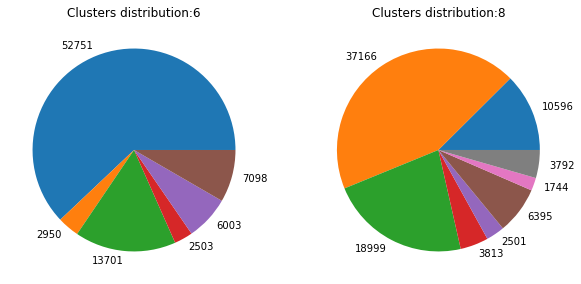

In [19]:
pie, ax = plt.subplots(figsize=[10, 6])
for i, k in enumerate(k_list):
    data = data_all.groupby('cluster_kmeans_ngram_' + str(k))['id'].count()
    plt.subplot(1, 2, i+1)
    plt.pie(x=data, labels=data.values);
    plt.title("Clusters distribution:" + str(k), fontsize=12);

Посмотрим на наиболее частые слова из названий законопроектов каждого кластера:

In [20]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))

In [21]:
print('Вариант 1:')
get_top_keywords(X, data_all['cluster_kmeans_ngram_6'], vectorizer.get_feature_names(), 10)

print('\nВариант 2:')
get_top_keywords(X, data_all['cluster_kmeans_ngram_8'], vectorizer.get_feature_names(), 10)

Вариант 1:

Cluster 0
организац,росс,прав,порядк,российск федерац,федерац,российск,государствен,федеральн,утвержден

Cluster 1
федеральн государствен,подготовк,стандарт,образовательн,стандарт высш,государствен образовательн,образовательн стандарт,образован,высш образован,высш

Cluster 2
изменен приказ,внесен,внесен изменен,изменен,приказ министерств,приказ,министерств,российск,российск федерац,федерац

Cluster 3
стандарт работник,специалист област,производств,утвержден,специалист,стандарт специалист,стандарт,профессиональн,утвержден профессиональн,профессиональн стандарт

Cluster 4
внесен,внесен изменен,российск,российск федерац,федерац,изменен постановлен,постановлен,постановлен правительств,правительств российск,правительств

Cluster 5
российск федерац,изменен стат,кодекс российск,кодекс,стат,изменен,внесен,внесен изменен,федеральн закон,закон

Вариант 2:

Cluster 0
надзор,гражданск,агентств,утвержден,государствен гражданск,федеральн государствен,федеральн служб,государствен,служб,фе

Посмотрим на распределение целевой переменной в зависимости от принадлежности законопроекта определенному кластеру:

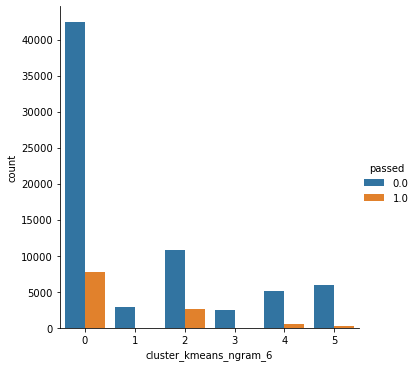

In [22]:
sns.catplot(x='cluster_kmeans_ngram_6', data=data_all, hue='passed', kind='count');

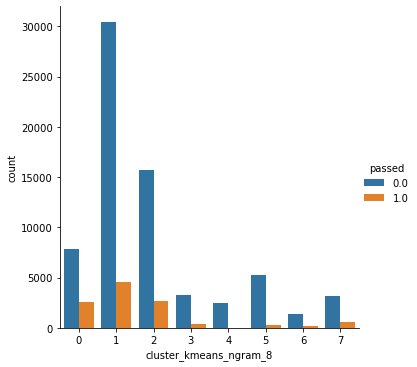

In [23]:
sns.catplot(x='cluster_kmeans_ngram_8', data=data_all, hue='passed', kind='count');

Можно сделать вывод, что оба варианта кластеризации несут определенный смысл и могут помочь в решении задачи.

# 3.Обработка остальных полей regulations.csv

In [24]:
data_all.head()

,id,act_title,publication_date,developer,okved_list,views_num,comments_num,likes_num,dislikes_num,regulatory_impact,...,act_objectives,persons_affected_by_act,relations_regulated_by_act,act_significance,na_counts,passed,act_title_clear,act_title_lem,cluster_kmeans_ngram_6,cluster_kmeans_ngram_8
0,5038,Об утверждении тарифов на услуги по транспорти...,2013-09-11,ФСТ России,NaN,376.0,0.0,0.0,0.0,Низкая,...,NaN,NaN,NaN,NaN,6,0.0,утверждении тарифов услуги транспортировке газ...,утвержден тариф услуг транспортировк газ газор...,0,1
1,5039,О внесении изменений в отдельные законодательн...,2013-06-11,Минтруд России,Здравоохранение; Предоставление социальных услуг,504.0,0.0,0.0,0.0,Низкая,...,NaN,NaN,NaN,NaN,5,0.0,внесении изменений отдельные законодательные а...,внесен изменен отдельн законодательн акт росси...,5,5
2,5040,Об утверждении Положения об уведомлении лиц об...,2013-04-29,Росфинмониторинг,Финансовая деятельность,428.0,0.0,0.0,0.0,Низкая,...,NaN,NaN,NaN,NaN,5,0.0,утверждении положения уведомлении лиц включени...,утвержден положен уведомлен лиц включен список...,0,1
3,5041,О внесении изменений в Положение о Министерств...,2013-10-21,Минобрнауки России,Образование,376.0,0.0,0.0,0.0,Низкая,...,NaN,NaN,NaN,NaN,5,1.0,внесении изменений положение министерстве обра...,внесен изменен положен министерств образован н...,2,2
4,5042,О внесении изменений в Правила подготовки и пр...,2014-02-24,Минприроды России,NaN,499.0,0.0,0.0,0.0,Низкая,...,Пунктом 12 части 2 статьи 11 Водного кодекса Р...,неопределенный круг лиц,необходимость корреляции Правил подготовки и п...,Проект постановления Правительства Российской ...,1,NaN,внесении изменений правила подготовки принятия...,внесен изменен прав подготовк принят решен пре...,0,2


## 3.1. publication_date

In [25]:
data_all['publication_date'].unique()

array(['2013-09-11', '2013-06-11', '2013-04-29', ..., '2021-09-06',
       '2021-09-07', '2021-09-08'], dtype=object)

In [26]:
data_all['publication_year'] = pd.to_datetime(data_all['publication_date'], format='%Y-%m-%d', errors='coerce').dt.year
data_all['publication_month'] = pd.to_datetime(data_all['publication_date'], format='%Y-%m-%d', errors='coerce').dt.month
data_all['publication_day'] = pd.to_datetime(data_all['publication_date'], format='%Y-%m-%d', errors='coerce').dt.day

data_all.drop(['act_title', 'publication_date', 'act_title_clear', 'act_title_lem'], axis=1, inplace=True)

## 3.2. okved_list

In [27]:
okveds_all = data_all['okved_list'].unique()
sorted(okveds_all, key=lambda x: len(x) if x==x else 0, reverse=True)[12]

'Добыча полезных ископаемых, кроме топливно-энергетических; Производство пищевых продуктов, включая напитки, и табака; Текстильное и швейное производство; Производство кожи, изделий из кожи; Обработка древесины и производство изделий из дерева; Целлюлозно-бумажное производство; Химическое производство; Производство резиновых изделий; Производство прочих неметаллических минеральных продуктов; Металлургическое производство; Производство машин и оборудования; Производство электрооборудования; Производство транспортных средств; Прочие производства; Строительство; Оптовая и розничная торговля; Предоставление прочих коммунальных, социальных и персональных услуг; Производство обуви; Производство готовых металлических изделий; Производство оборудования; Производство бытовых изделий и предметов личного пользования'

In [28]:
okved_set = set()
max_okveds_count = 0

for okved_list in okveds_all:
    if okved_list != okved_list:
        continue
    okveds_count = 0
    for okved in okved_list.split(';'):
        okved = okved.strip()
        okved_set.add(okved)
        okveds_count += 1
    if okveds_count > max_okveds_count:
        max_okveds_count = okveds_count

In [29]:
print('Максимальное количество указанных ОКВЭД у одного законопроекта:', max_okveds_count)
print('Всего различных упоминаемых ОКВЭД:', len(okved_set))

Максимальное количество указанных ОКВЭД у одного законопроекта: 53
Всего различных упоминаемых ОКВЭД: 57


In [30]:
sorted(list(okved_set))

['Внешнеэкономическая деятельность',
 'Гостиницы и рестораны',
 'Государственное управление',
 'Деятельность домашних хозяйств',
 'Деятельность экстерриториальных организаций',
 'Добыча полезных ископаемых, кроме топливно-энергетических',
 'Добыча топливно-энергетических полезных ископаемых',
 'Здравоохранение',
 'Издательская и полиграфическая деятельность',
 'Информационные технологии',
 'Корпоративное управление',
 'Лесное хозяйство',
 'Металлургическое производство',
 'Налоговое администрирование',
 'Нефтепродукты',
 'Обеспечение военной безопасности',
 'Обработка древесины и производство изделий из дерева',
 'Образование',
 'Операции с недвижимым имуществом, аренда и предоставление услуг',
 'Оптовая и розничная торговля',
 'Охота',
 'Персональные данные',
 'Пластмассовые изделия',
 'Правоохранительная деятельность',
 'Предоставление прочих коммунальных, социальных и персональных услуг',
 'Предоставление социальных услуг',
 'Производство бытовых изделий и предметов личного пользова

Создадим матрицу упомянутых ОКВЭД для каждого законопроекта:

In [31]:
data_okveds = []
okved_names = sorted(list(okved_set))

for okv_lst in tqdm(data_all['okved_list']):
    coded_list = [0] * len(okved_set)
    if okv_lst == okv_lst:
        for okved in okv_lst.split(';'):
            okved = okved.strip()
            coded_list[okved_names.index(okved)] = 1
    data_okveds.append(coded_list)

100%|████████████████████████████████| 85006/85006 [00:00<00:00, 352646.73it/s]


In [32]:
pd.DataFrame(data_okveds)

,0,1,2,3,4,5,6,7,8,9,...,47,48,49,50,51,52,53,54,55,56
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
85002,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
85003,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
85004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Данные признаки не оказали положительного влияния на качество модели, поэтому в итоговую модель не вошли.

## 3.3. regulatory_impact, mineco_solution

In [33]:
data_all['regulatory_impact'].value_counts(dropna=False)

Не определена    57404
Низкая           18105
Средняя           6633
Высокая           2275
NaN                589
Name: regulatory_impact, dtype: int64

In [34]:
imp_dict = {'Низкая': 1, 'Средняя': 2, 'Высокая': 3, 'Не определена': 0}
data_all['regulatory_impact'] = data_all['regulatory_impact'].map(imp_dict)

In [35]:
data_all['mineco_solution'].value_counts(dropna=False)

Не определено    76156
Положительное     5860
Отрицательное     2401
NaN                589
Name: mineco_solution, dtype: int64

In [36]:
solution_dict = {'Отрицательное': 1, 'Положительное': 2, 'Не определено': 0}
data_all['mineco_solution'] = data_all['mineco_solution'].map(solution_dict)

## 3.4. is_regionally_signigicant, act_changes_controlling_activities

In [37]:
data_all['is_regionally_signigicant'].value_counts(dropna=False)

False    83785
True       632
NaN        589
Name: is_regionally_signigicant, dtype: int64

In [38]:
data_all['act_changes_controlling_activities'].value_counts(dropna=False)

False    83360
True      1057
NaN        589
Name: act_changes_controlling_activities, dtype: int64

In [39]:
data_all['is_regionally_signigicant'] = data_all['is_regionally_signigicant'].fillna(-1).astype(int)
data_all['act_changes_controlling_activities'] = data_all['act_changes_controlling_activities'].fillna(-1).astype(int)

## 3.5. developer, problem_addressed, act_objectives, persons_affected_by_act, relations_regulated_by_act, act_significance

In [40]:
data_all['developer'].value_counts(dropna=False)

Минобрнауки России                                            6258
Минтруд России                                                6254
Минтранс России                                               5062
Минфин России                                                 5053
Минэкономразвития России                                      4757
                                                              ... 
Федеральная служба по оборонному заказу                         20
Рособоронпоставка                                               18
Коллегия Военно-промышленной комиссии Российской Федерации      15
СВР России                                                       2
Департамент энергетики Правительства Российской Федерации        1
Name: developer, Length: 99, dtype: int64

In [41]:
data_all['problem_addressed'].value_counts(dropna=False)

NaN                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      66505
Изменения во ФГОС                                                                                                                                                                                                                                                                                                                                                                                        

In [42]:
data_all['act_objectives'].value_counts(dropna=False)

NaN                                                                                                                                                                                                                                                                                                                                                                            74325
Изменения во ФГОС                                                                                                                                                                                                                                                                                                                                                                425
внесение изменений во ФГОС                                                                                                                                                                                                                                    

In [43]:
data_all['persons_affected_by_act'].value_counts(dropna=False)

NaN                                                                                                                                                                                                                                      66504
Росреестр                                                                                                                                                                                                                                 1049
вузы                                                                                                                                                                                                                                       649
сотрудники органов внутренних дел Российской Федерации                                                                                                                                                                                     484
Не ограниченный круг лиц                    

In [44]:
data_all['relations_regulated_by_act'].value_counts(dropna=False)

NaN                                                                                                                                                                                                                                                                                                                                                                                                                                                                        66502
Изменения во ФГОС                                                                                                                                                                                                                                                                                                                                                                                                                                                            425
-                                                                     

In [45]:
data_all['act_significance'].value_counts(dropna=False)

NaN                                                                                                                                                                                                                                     66505
Федеральный закон от 29 декабря 2012 г. № 273-ФЗ «Об образовании в Российской Федерации»                                                                                                                                                  425
Федеральный закон от 29 декабря 2012 г. № 273-ФЗ "Об образовании в Российской Федерации"                                                                                                                                                  202
В соответствии с частью 1 статьи 34 Федерального закона от 04.12.2007 № 329-ФЗ «О физической культуре и спорте в Российской Федерации».                                                                                                    87
Разработка проекта предусмотрена частью 1 статьи

Для данных признаков применим токенизацию и последующий Label Encoding

## 3.6. added_by, responsible

In [46]:
data_all[data_all['added_by'] == data_all['responsible']]['passed'].mean(), \
data_all[data_all['added_by'] != data_all['responsible']]['passed'].mean()

(0.1482444733420026, 0.1314045037930457)

Можем заметить, что на значение целевого признака влияет факт того, что законопроект внес тот же человек, который является за него ответственным.

Введем соответствующий признак: **added_resp** - у законопроекта совпадают эти два поля:

In [47]:
data_all['added_resp'] = (data_all['added_by'] == data_all['responsible']).astype(int)

Применим токенизацию и Label Encoding:

In [48]:
name_cols = ['added_by', 'responsible']
other_cols_to_encode = [ 'okved_list', 'developer', 'problem_addressed', 'act_objectives',
                        'persons_affected_by_act', 'relations_regulated_by_act', 'act_significance']

In [49]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(data_all[name_cols].fillna('na').values.reshape(-1))

LabelEncoder()

In [50]:
for col in name_cols:
    data_all[col] = le.transform(data_all[col].fillna('na'))

In [51]:
for col in tqdm(other_cols_to_encode):
    data_all[col] = le.fit_transform(data_all[col].map(clear_text).fillna('na'))

100%|████████████████████████████████████████████| 7/7 [00:15<00:00,  2.18s/it]


In [53]:
data_all.isna().sum().sort_values(ascending=False)

passed                                4000
mineco_solution                        589
publication_month                      589
publication_year                       589
views_num                              589
comments_num                           589
likes_num                              589
dislikes_num                           589
regulatory_impact                      589
publication_day                        589
is_regionally_signigicant                0
developer                                0
okved_list                               0
added_by                                 0
responsible                              0
added_resp                               0
act_changes_controlling_activities       0
problem_addressed                        0
act_objectives                           0
persons_affected_by_act                  0
relations_regulated_by_act               0
act_significance                         0
na_counts                                0
cluster_kme

Пропущенные значения заменим на -1:

In [54]:
cols_with_nans = [
'publication_day',
'publication_year',
'views_num',
'comments_num',
'likes_num',
'dislikes_num',
'mineco_solution',
'publication_month',
'regulatory_impact'
]

for col in cols_with_nans:
    data_all[col] = data_all[col].fillna(-1).astype(int)

In [55]:
data_all.head()

,id,developer,okved_list,views_num,comments_num,likes_num,dislikes_num,regulatory_impact,added_by,responsible,...,relations_regulated_by_act,act_significance,na_counts,passed,cluster_kmeans_ngram_6,cluster_kmeans_ngram_8,publication_year,publication_month,publication_day,added_resp
0,5038,94,0,376,0,0,0,1,4949,4949,...,9,9,6,0.0,0,1,2013,9,11,1
1,5039,30,160,504,0,0,0,1,6202,5598,...,9,9,5,0.0,5,5,2013,6,11,0
2,5040,72,780,428,0,0,0,1,7368,4497,...,9,9,5,0.0,0,1,2013,4,29,0
3,5041,21,220,376,0,0,0,1,1596,4977,...,9,9,5,1.0,2,2,2013,10,21,0
4,5042,22,0,499,0,0,0,1,6932,6932,...,2964,6863,1,NaN,0,2,2014,2,24,1


# 4. Добавим признаки из ria_reports_main.csv

In [56]:
main_rep_df = pd.read_csv(REP_PATH + 'ria_reports_main.csv', delimiter=';')
main_rep_df.head(3)

,regulation_project_id,header: id,general_info: Федеральный орган исполнительной власти (далее – разработчик),general_info: Сведения о федеральных органах исполнительной власти – соисполнителях,general_info: Вид и наименование проекта акта,"general_info: Краткое описание проблемы, на решение которой направлен предлагаемый способ регулирования",general_info: Основание для разработки проекта акта,general_info: Краткое описание целей предлагаемого регулирования,general_info: Краткое описание предлагаемого способа регулирования,general_info: Контактная информация исполнителя разработчика,...,anticorr_expertise: Указать (при наличии) количество поступивших заключений от независимых экспертов (шт.),anticorr_expertise: Выявленные коррупциогенные факторы и их способы устранения,"other_notification_info: Иные необходимые, по мнению разработчика, сведения",other_notification_info: Источники данных,public_discussion: Полный электронный адрес размещения проекта акта в информационно-телекоммуникационной сети «Интернет»,"public_discussion: Сведения о федеральных органах исполнительной власти и представителях предпринимательского сообщества, извещенных о проведении публичных консультаций","public_discussion: Сведения о лицах, представивших предложения","public_discussion: Сведения о структурных подразделениях разработчика, рассмотревших предоставленные предложения",public_discussion: Иные сведения о проведении публичного обсуждения проекта акта,"cancel_duties: Нормативный правовой акт, в котором содержатся отменяемые обязанности, запреты или ограничения"
0,7208,00/03-14385/04-14/13-5-5,Министерство транспорта Российской Федерации -...,Министерство труда и социальной защиты Российс...,"Проект приказа Минтранса России ""О внесении из...",Отсутствие нормативного регулирования предоста...,Проект разработан в рамках реализации Федераль...,Нормативное регулирование предоставления услуг...,Утверждение предлагаемых изменений,"Сухарникова Екатерина Андреевна, Главный специ...",...,нет,нет,Проект согласован Минтрудом России письмом от ...,нет,http://regulation.gov.ru/projects#npa=7208,"Минэкономразвития России, АЭВТ, ОАО ""Авиакомпа...",,,нет,нет
1,7243,00/03-3240/06-13/10-13-2,Роспотребнадзор,нет,Проект постановления Главного государственного...,Установление требований к инсоляции (облучению...,- Федеральный закон от 30.03.1999 № 52-ФЗ «О с...,В целях обеспечения безопасности здоровья насе...,В целях обеспечения безопасности здоровья насе...,"Гуськов Андрей Сергеевич , заместитель начальн...",...,[o_11_1],[o_11_2],[o_12_1],[o_12_2],http://regulation.gov.ru/projects#npa=47103,[o_13_3],[o_13_4],-,-,non-applicable
2,7258,00/03-3241/06-13/10-13-2,Федеральная служба по надзору в сфере защиты п...,Отсутствуют,Проект постановления Главного государственного...,Согласно п. 1 ст. 25 Федерального закона от 30...,План разработки нормативных правовых актов сан...,Установление санитарно-эпидемиологических треб...,Установление санитарно-эпидемиологических треб...,"Мурагимов Тимур Ильдарович, главный специалист...",...,[o_17_1],[o_17_2],[o_18_1],[o_18_2],[o_19_1],[o_19_3],[o_19_4],[o_19_5],[o_19_6],non-applicable


In [57]:
main_rep_df.shape

(8807, 61)

In [58]:
main_rep_df['regulation_project_id'].value_counts()[:5]

117661    2
60767     1
73065     1
42342     1
81253     1
Name: regulation_project_id, dtype: int64

Заметим, что законопроект с id 117661 содержится здесь дважды

In [59]:
main_rep_df[main_rep_df['regulation_project_id'] == 117661]

,regulation_project_id,header: id,general_info: Федеральный орган исполнительной власти (далее – разработчик),general_info: Сведения о федеральных органах исполнительной власти – соисполнителях,general_info: Вид и наименование проекта акта,"general_info: Краткое описание проблемы, на решение которой направлен предлагаемый способ регулирования",general_info: Основание для разработки проекта акта,general_info: Краткое описание целей предлагаемого регулирования,general_info: Краткое описание предлагаемого способа регулирования,general_info: Контактная информация исполнителя разработчика,...,anticorr_expertise: Указать (при наличии) количество поступивших заключений от независимых экспертов (шт.),anticorr_expertise: Выявленные коррупциогенные факторы и их способы устранения,"other_notification_info: Иные необходимые, по мнению разработчика, сведения",other_notification_info: Источники данных,public_discussion: Полный электронный адрес размещения проекта акта в информационно-телекоммуникационной сети «Интернет»,"public_discussion: Сведения о федеральных органах исполнительной власти и представителях предпринимательского сообщества, извещенных о проведении публичных консультаций","public_discussion: Сведения о лицах, представивших предложения","public_discussion: Сведения о структурных подразделениях разработчика, рассмотревших предоставленные предложения",public_discussion: Иные сведения о проведении публичного обсуждения проекта акта,"cancel_duties: Нормативный правовой акт, в котором содержатся отменяемые обязанности, запреты или ограничения"
8752,117661,02/04/07-21/00117661,Минвостокразвития России,"Минприроды России, Минфин России","""О внесении изменений в статью 343.6 части вто...",Высокие издержки на создание инфраструктуры дл...,пункт 82 плана законопроектной деятельности Пр...,Стимулирование инвестиционной деятельности в о...,Предоставление налогового вычета по налогу на ...,"Дависвич О.Г., Заместитель директора Администр...",...,[o_18_1],[o_18_2],[o_19_1],[o_19_2],[o_20_1],[o_20_3],[o_20_4],[o_20_5],[o_20_6],-
8753,117661,02/04/07-21/00117661,Минвостокразвития России,"Минприроды России, Минфин России","""О внесении изменений в статью 343.6 части вто...",Высокие издержки на создание инфраструктуры дл...,пункт 82 плана законопроектной деятельности Пр...,Стимулирование инвестиционной деятельности в о...,Предоставление налогового вычета по налогу на ...,"Дависвич О.Г., Заместитель директора Администр...",...,0,0,-,-,,[o_19_3],[o_19_4],[o_19_5],[o_19_6],non-applicable


Оставим одну запись об этом законопроекте:

In [60]:
main_rep_df.drop(8752, axis=0, inplace=True)

Посмотрим на поле 'degree: Степень регулирующего воздействия проекта акта':

In [62]:
main_rep_df['degree: Степень регулирующего воздействия проекта акта'].value_counts(dropna=False)

Средняя                                                                            4579
Низкая                                                                             2086
Высокая                                                                            1577
средняя                                                                             243
низкая                                                                              218
высокая                                                                              85
Средняя.                                                                              4
Даныые будут предоставлены по результатам общественного обсуждения проекта акта       1
Будет заполнено в процессе общественного обсуждения                                   1
Информация будет внесена по завершению общественного обсуждения Проекта акта          1
СРЕДНЯЯ                                                                               1
Данные будкут внесены в ходе обс

Много 'замусоренных' значений, обработаем их:

In [63]:
degree_dict = {'низкая': 1, 'средняя': 2, 'высокая': 3}

def get_degree(degree_str):
    degree_str_clear = degree_str.lower().strip()
    if degree_str_clear in degree_dict:
        return degree_dict[degree_str_clear]
    return 0

In [64]:
main_rep_df['degree'] = main_rep_df['degree: Степень регулирующего воздействия проекта акта'].map(get_degree)

Для каждого отчета посчитаем степень его заполненности как общее количество символов во всех полях отчета:

In [66]:
cols_to_calc_len = main_rep_df.columns[2:-2]

len_sum = []

strs_to_sum = main_rep_df.loc[:, cols_to_calc_len].values

for i in tqdm(range(len(strs_to_sum))):
    vals = [str(val) for val in strs_to_sum[i] if val==val]
    sum_row = len("".join(vals))
    len_sum.append(sum_row)

100%|███████████████████████████████████| 8806/8806 [00:00<00:00, 66585.02it/s]


In [67]:
main_rep_df['rep_len_sum'] = len_sum

Оценим влияние полей отчета на целевую переменную. Для этого сделаем LabelEncoding всех полей и воспользуемся Cramérs V в качестве меры ассоциации между двумя категориальными переменными:

In [79]:
reps_df = main_rep_df.merge(data_all[['id', 'passed']].rename(columns={'id': 'regulation_project_id'}), \
                            on='regulation_project_id', how='left')

reps_df = reps_df[~reps_df['passed'].isna()]
reps_df['passed'] = reps_df['passed'].astype(int)

In [80]:
import scipy.stats as stats

rep_cols = [col for col in reps_df.columns[2:-3]]
target_vals = reps_df['passed'].values

lenc = LabelEncoder()

rep_feat_imp = []

for col in rep_cols:
    col_vals = reps_df[col].fillna('nan').values
    col_vals = lenc.fit_transform(col_vals) + 1
    matrix = np.vstack((col_vals, target_vals)).T
    
    X2 = stats.chi2_contingency(matrix, correction=False)[0]
    n = np.sum(matrix)
    minDim = min(matrix.shape) - 1
    V = np.sqrt((X2/n) / minDim)
    rep_feat_imp.append([col, V])

In [83]:
[print(x, y) for x, y in sorted(rep_feat_imp, key=lambda x: x[1], reverse=True)[:7]]

degree: Степень регулирующего воздействия проекта акта 0.3973687905160855
other_notification_info: Источники данных 0.3379936449057262
public_discussion: Иные сведения о проведении публичного обсуждения проекта акта 0.3307742900276359
public_discussion: Сведения о лицах, представивших предложения 0.32332375176628053
anticorr_expertise: Выявленные коррупциогенные факторы и их способы устранения 0.3179829167213285
public_discussion: Сведения о структурных подразделениях разработчика, рассмотревших предоставленные предложения 0.31739777836063043
other_notification_info: Иные необходимые, по мнению разработчика, сведения 0.3149393127056094


[None, None, None, None, None, None, None]

Видим, что признак 'degree: Степень регулирующего воздействия проекта акта' оказывает наибольшее значение на целевую переменную. Добавим этот признак и степень заполненности отчета к основному датасету:

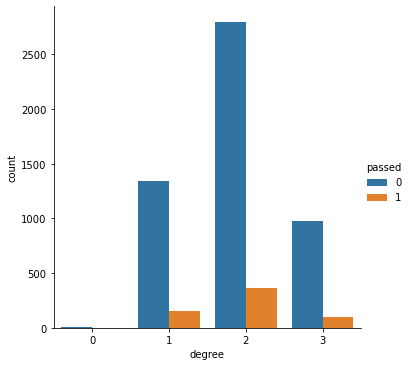

In [78]:
sns.catplot(x='degree', data=reps_df, hue = 'passed', kind = 'count');

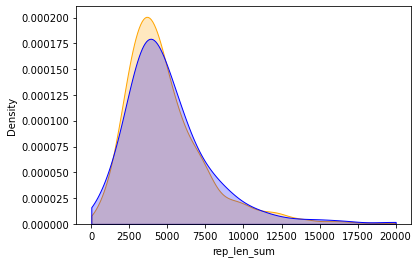

In [85]:
sns.kdeplot(reps_df['rep_len_sum'][reps_df['passed'] == 0], color='orange', clip=(0, 20000), shade=True);
sns.kdeplot(reps_df['rep_len_sum'][reps_df['passed'] == 1], color='blue', clip=(0, 20000), shade=True);

In [74]:
data_all = data_all.merge(main_rep_df[['regulation_project_id', 'degree', 'rep_len_sum']] \
                .rename(columns={'regulation_project_id': 'id'}), on='id', how='left')

In [75]:
data_all['degree'] = data_all['degree'].fillna(-1).astype(int)
data_all['rep_len_sum'] = data_all['rep_len_sum'].fillna(-1).astype(int)

# 5. Добавим объем текста законопроекта из ria_reports_main.csv

In [87]:
reg_texts = pd.read_csv(PATH + 'regulations_texts.csv', delimiter=';')
reg_texts.head()

,regulation_project_id,text
0,100001,\nПроект\n\nПРАВИТЕЛЬСТВО РОССИЙСКОЙ ФЕДЕРАЦИИ...
1,100002,\nПроект\n\nПРАВИТЕЛЬСТВО РОССИЙСКОЙ ФЕДЕРАЦИИ...
2,100006,\nпроект\n\nО внесении изменения в Правила заг...
3,100014,\nПроект\n\nПРАВИТЕЛЬСТВО РОССИЙСКОЙ ФЕДЕРАЦИИ...
4,100016,\nПРОЕКТ\n\nПРАВИТЕЛЬСТВО РОССИЙСКОЙ ФЕДЕРАЦИИ...


In [88]:
reg_texts.shape

(11384, 2)

In [89]:
reg_texts['text_len'] = reg_texts['text'].map(len)

In [90]:
data_all = data_all.merge(reg_texts.rename(columns={'regulation_project_id': 'id'})[['id', 'text_len']], on='id', how='left')

In [91]:
data_all['text_len'] = data_all['text_len'].fillna(-1).astype(int)

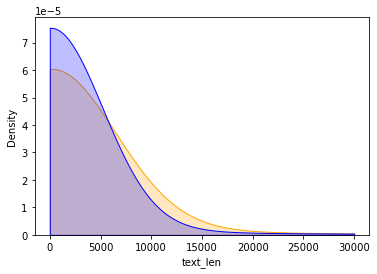

In [92]:
sns.kdeplot(data_all['text_len'][data_all['passed'] == 0], color='orange', clip=(0, 3e4), shade=True);
sns.kdeplot(data_all['text_len'][data_all['passed'] == 1], color='blue', clip=(0, 3e4), shade=True);

Можем заметить, что объем текста законопроекта действительно связан со значением целевой переменной.

In [71]:
data_all.columns

Index(['id', 'developer', 'okved_list', 'views_num', 'comments_num',
       'likes_num', 'dislikes_num', 'regulatory_impact', 'added_by',
       'responsible', 'is_regionally_signigicant',
       'act_changes_controlling_activities', 'mineco_solution',
       'problem_addressed', 'act_objectives', 'persons_affected_by_act',
       'relations_regulated_by_act', 'act_significance', 'na_counts', 'passed',
       'cluster_kmeans_new_3', 'cluster_kmeans_new_4', 'cluster_kmeans_new_5',
       'cluster_kmeans_new_6', 'cluster_kmeans_new_7', 'cluster_kmeans_new_8',
       'cluster_kmeans_ngram_3', 'cluster_kmeans_ngram_4',
       'cluster_kmeans_ngram_5', 'cluster_kmeans_ngram_6',
       'cluster_kmeans_ngram_7', 'cluster_kmeans_ngram_8', 'publication_year',
       'publication_month', 'publication_day', 'added_resp', 'degree',
       'rep_len_sum', 'text_len'],
      dtype='object')

# 6. Финальная модель

In [93]:
data_all.head()

,id,developer,okved_list,views_num,comments_num,likes_num,dislikes_num,regulatory_impact,added_by,responsible,...,passed,cluster_kmeans_ngram_6,cluster_kmeans_ngram_8,publication_year,publication_month,publication_day,added_resp,degree,rep_len_sum,text_len
0,5038,94,0,376,0,0,0,1,4949,4949,...,0.0,0,1,2013,9,11,1,-1,-1,-1
1,5039,30,160,504,0,0,0,1,6202,5598,...,0.0,5,5,2013,6,11,0,-1,-1,-1
2,5040,72,780,428,0,0,0,1,7368,4497,...,0.0,0,1,2013,4,29,0,-1,-1,-1
3,5041,21,220,376,0,0,0,1,1596,4977,...,1.0,2,2,2013,10,21,0,-1,-1,-1
4,5042,22,0,499,0,0,0,1,6932,6932,...,NaN,0,2,2014,2,24,1,-1,-1,2837


In [94]:
data_all.columns

Index(['id', 'developer', 'okved_list', 'views_num', 'comments_num',
       'likes_num', 'dislikes_num', 'regulatory_impact', 'added_by',
       'responsible', 'is_regionally_signigicant',
       'act_changes_controlling_activities', 'mineco_solution',
       'problem_addressed', 'act_objectives', 'persons_affected_by_act',
       'relations_regulated_by_act', 'act_significance', 'na_counts', 'passed',
       'cluster_kmeans_ngram_6', 'cluster_kmeans_ngram_8', 'publication_year',
       'publication_month', 'publication_day', 'added_resp', 'degree',
       'rep_len_sum', 'text_len'],
      dtype='object')

In [79]:
# Сохраним финальный датасет, чтобы не запускать заново весь ноутбук

# data_all.to_csv(PATH + 'regulations_final.csv', index=False)

# data_all = pd.read_csv(PATH + 'regulations_final.csv')

In [96]:
data_train = data_all[~data_all['passed'].isna()]
data_test = data_all[data_all['passed'].isna()]

In [97]:
feats_to_del = ['passed', 'id', 
                'problem_addressed', 'act_significance'] # Данные признаки оказали негативное влияние на качество модели

X_train = data_train.drop(feats_to_del, axis=1)
X_test = data_test.drop(feats_to_del, axis=1)

y = data_train['passed'].astype(int)

In [99]:
X_train.shape, X_test.shape

((81006, 25), (4000, 25))

In [103]:
X_train_ctb, X_val_ctb, y_train_ctb, y_val_ctb = train_test_split(X_train, y, test_size=0.2, \
                                shuffle=True, stratify=y, random_state=SEED, )

Разделим все признаки на числовые и категориальные:

In [104]:
cat_cols = list(['developer', 'okved_list', 'added_by', 'responsible', 'act_changes_controlling_activities', \
            'act_objectives', 'persons_affected_by_act', 'relations_regulated_by_act', \
            'publication_year', 'publication_month', 'publication_day', 'mineco_solution', \
           'regulatory_impact', 'is_regionally_signigicant', 'cluster_kmeans_ngram_6', 'cluster_kmeans_ngram_8', \
                 'added_resp', 'degree'] )

cat_cols = set(cat_cols) - set(feats_to_del)
cat_cols

{'act_changes_controlling_activities',
 'act_objectives',
 'added_by',
 'added_resp',
 'cluster_kmeans_ngram_6',
 'cluster_kmeans_ngram_8',
 'degree',
 'developer',
 'is_regionally_signigicant',
 'mineco_solution',
 'okved_list',
 'persons_affected_by_act',
 'publication_day',
 'publication_month',
 'publication_year',
 'regulatory_impact',
 'relations_regulated_by_act',
 'responsible'}

In [105]:
num_cols = set(X_train.columns) - set(cat_cols)
num_cols

{'comments_num',
 'dislikes_num',
 'likes_num',
 'na_counts',
 'rep_len_sum',
 'text_len',
 'views_num'}

Воспользуемся одной из реализаций градиентного бустинга - CatBoost. Этот классификатор хорошо работает с категориальными признаками, которых достаточно много в нашей модели: 

In [106]:
ctb = CatBoostClassifier(depth=7, iterations=1400, learning_rate=0.09, \
                         random_seed=SEED, eval_metric='AUC') 

ctb.fit(X_train_ctb, y_train_ctb, \
        cat_features=cat_cols, \
        eval_set=(X_val_ctb, y_val_ctb), \
        plot=True, verbose=50)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7884435	best: 0.7884435 (0)	total: 272ms	remaining: 6m 20s
50:	test: 0.9237748	best: 0.9237748 (50)	total: 8.31s	remaining: 3m 39s
100:	test: 0.9276045	best: 0.9276045 (100)	total: 17.2s	remaining: 3m 40s
150:	test: 0.9292569	best: 0.9292569 (150)	total: 25.9s	remaining: 3m 34s
200:	test: 0.9300941	best: 0.9301001 (199)	total: 34.8s	remaining: 3m 27s
250:	test: 0.9307236	best: 0.9307236 (250)	total: 43.5s	remaining: 3m 18s
300:	test: 0.9310689	best: 0.9310791 (298)	total: 52s	remaining: 3m 9s
350:	test: 0.9314293	best: 0.9314293 (350)	total: 1m	remaining: 3m 1s
400:	test: 0.9318382	best: 0.9318382 (400)	total: 1m 9s	remaining: 2m 54s
450:	test: 0.9320475	best: 0.9320716 (444)	total: 1m 19s	remaining: 2m 46s
500:	test: 0.9322468	best: 0.9322481 (490)	total: 1m 28s	remaining: 2m 37s
550:	test: 0.9326167	best: 0.9326353 (546)	total: 1m 37s	remaining: 2m 30s
600:	test: 0.9328683	best: 0.9328683 (600)	total: 1m 48s	remaining: 2m 24s
650:	test: 0.9329039	best: 0.9329569 (626)	tota

In [107]:
# Функция вывода информации о важности признаков в построенной модели
def print_feat_imp(feat_names, feat_values, n_features=30, draw_bar=True, print_val=False):
    max_name_len = 40
    feat_imp = dict(zip(feat_names, feat_values))
    feat_dict = sorted(feat_imp.items(), key=lambda item: abs(item[1]), reverse=True)
    if not n_features:
        n_features = len(feat_values)
    if print_val:    
        { print('{}: {:.6f}'.format(k, v)) for k, v in feat_dict[:n_features] }
    if draw_bar:
        plt.figure(figsize=(10, 8));
        sns.set(font_scale=1.1)
        bar = sns.barplot(y=list(map(lambda x: x[0][:max_name_len], feat_dict))[:n_features], \
            x=list(map(lambda x: x[1], feat_dict))[:n_features],
            orient='h');
        bar.set(title='Feature importance')

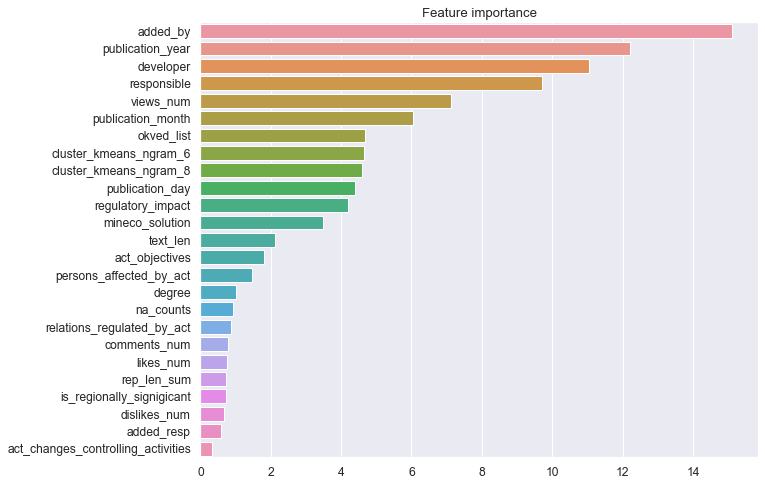

In [108]:
print_feat_imp(X_train.columns, ctb.get_feature_importance())

In [109]:
del ctb

Обучим модель на всех данных, увеличив количество итераций в 1.2 раза, и сделаем предсказание: 

In [110]:
ctb_final = CatBoostClassifier(depth=7, iterations=1580, learning_rate=0.09, \
                               random_seed=SEED) 

ctb_final.fit(X_train, y, \
        cat_features=cat_cols, \
        plot=True, verbose=200)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6133592	total: 192ms	remaining: 5m 2s
200:	learn: 0.2161730	total: 40.2s	remaining: 4m 35s
400:	learn: 0.2033423	total: 1m 23s	remaining: 4m 4s
600:	learn: 0.1939911	total: 2m 4s	remaining: 3m 22s
800:	learn: 0.1854469	total: 2m 45s	remaining: 2m 40s
1000:	learn: 0.1771107	total: 3m 26s	remaining: 1m 59s
1200:	learn: 0.1697774	total: 4m 10s	remaining: 1m 18s
1400:	learn: 0.1629863	total: 4m 53s	remaining: 37.5s
1579:	learn: 0.1574680	total: 5m 32s	remaining: 0us


In [119]:
y_test_prob_pred = ctb_final.predict_proba(X_test)[:, 1]
data_test['passed'] = y_test_prob_pred

<ipython-input-119-82f87f5a2852>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_test['passed'] = y_test_prob_pred


In [120]:
subm_my = pd.DataFrame(subm['id']).merge(data_test[['id', 'passed']], on='id', how='outer')

subm_my.to_csv(PATH + 'submission_ctb.csv', index=False)